In [1]:
def getWeights(d,size):
    '''
    d:fraction
    k:the number of samples
    w:weight assigned to each samples
    
    '''
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1) #sort and reshape the w
    return w

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
import yfinance as yf
def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download('AAPL', start = '2000-01-01',
                     auto_adjust=True,#only download adjusted data
                     end= '2010-12-31') 
    #my convention:always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df
Apple_stock = get_data('AAPL', '2000-01-01', '2010-12-31')   
price = Apple_stock['close']
price.head()

[*********************100%***********************]  1 of 1 completed


Date
1999-12-31    0.786033
2000-01-03    0.855796
2000-01-04    0.783644
2000-01-05    0.795111
2000-01-06    0.726304
Name: close, dtype: float64

In [3]:
w = getWeights(0.1, price.shape[0])
w

array([[-1.53159665e-05],
       [-1.53220599e-05],
       [-1.53281579e-05],
       ...,
       [-4.50000000e-02],
       [-1.00000000e-01],
       [ 1.00000000e+00]])

In [6]:
def weight_by_d(dRange=[0,1], nPlots=11, size=6):
    '''
    dRange: the range of d
    nPlots: the number of d we want to check
    size: the data points used as an example
    w: collection of w by different d value
    '''
    
    w=pd.DataFrame()
    
    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])\
        [::-1],columns=[d])
        w=w.join(w_,how='outer')
        
    return w
weight_by_d = weight_by_d()
weight_by_d

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
5,-0.0,-0.016117,-0.025536,-0.029720,-0.029952,-0.027344,-0.022848,-0.017267,-0.011264,-0.005371,0.0
4,-0.0,-0.020662,-0.033600,-0.040163,-0.041600,-0.039062,-0.033600,-0.026162,-0.017600,-0.008663,0.0
3,-0.0,-0.028500,-0.048000,-0.059500,-0.064000,-0.062500,-0.056000,-0.045500,-0.032000,-0.016500,0.0
2,-0.0,-0.045000,-0.080000,-0.105000,-0.120000,-0.125000,-0.120000,-0.105000,-0.080000,-0.045000,0.0
1,-0.0,-0.100000,-0.200000,-0.300000,-0.400000,-0.500000,-0.600000,-0.700000,-0.800000,-0.900000,-1.0
0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [8]:
def plotWeights(w, v=2):    
    ax=w.plot()
    ax.axvline(x=v, c='c', linestyle='-.', lw=2.5, alpha=0.4)
    ax.axhline(y=0, c='c', linestyle='-.', lw=2.5, alpha=0.4)
    ax.legend(loc='upper right');
    ax.set_ylabel('Weight')
    ax.set_xlabel('Number of data points')
plotWeights(weight_by_d([0,1]));

TypeError: 'DataFrame' object is not callable

In [9]:
weight_by_d_1_2 = weight_by_d([1,2])
weight_by_d_1_2

TypeError: 'DataFrame' object is not callable

In [10]:
plotWeights(weight_by_d_1_2, v=3);

NameError: name 'weight_by_d_1_2' is not defined

In [11]:
def get_skip(series,d = 0.1,thres=.01):
    '''
    This part is independent of stock price data.
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped.
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    
    #1) Compute weights for the longest series
    w=getWeights(d,series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]
    
    return skip

In [12]:
def transfor_data_by_frac_diff(col,d = 0.1,thres=.01):
    #3) Apply weights to values
    df = pd.Series()
    skip = get_skip(col)
    
    for i in range(skip, col.shape[0]):
        i_index = col.index[i]
        data = np.dot(w[-(i+1):,:].T, col.loc[:i_index])[0]
        
        df[i_index] = data
                   
    return df

In [13]:
def trans_a_bunch_of_data(df,d = 0.1,thres=.01):
    a_bunch_of_trans_data = pd.DataFrame()
    
    for col in df.columns:
        trans_data = transfor_data_by_frac_diff(df[col] \
          ,d =   d,thres=thres)
        a_bunch_of_trans_data[col] = trans_data
    
    return a_bunch_of_trans_data

In [14]:
def getWeights_FFD(d=0.1, thres=1e-5):
    
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)

In [15]:
w_FFD = getWeights_FFD(thres=1e-4)
w_FFD.shape

(503, 1)

In [27]:
def transfer_data_by_frac_diff_FFD(col, d=0.1, thres=1e-4):
    #3) Apply weights to values
    w=getWeights_FFD(d,thres)
    width=len(w)-1
    
    df = pd.Series()
    #widow size can't be larger than the size of data
    if width >= col.shape[0]:raise Exception("width is oversize")
        
    for i in range(width, col.shape[0]):
        i_0_index, i_1_index = col.index[i-width], col.index[i]
        data = np.dot(w.T, col.loc[i_0_index:i_1_index])[0]
        
        df[i_1_index] = data
                   
    return df

In [28]:
price_trans = transfer_data_by_frac_diff_FFD(price)
price_trans.shape, price.shape

<ipython-input-27-8961113669e2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.Series()


((2265,), (2767,))

In [29]:
def trans_a_bunch_of_data_FFD(df, d=0.1, thres=1e-4):
    a_bunch_of_trans_data = pd.DataFrame()
    
    for col in df.columns:
        trans_data = transfer_data_by_frac_diff_FFD(df[col], \
                     d=d, thres=thres)
        a_bunch_of_trans_data[col] = trans_data
    
    return a_bunch_of_trans_data
trans_a_bunch_of_data_FFD(Apple_stock, d=0.1, thres=1e-4)


<ipython-input-27-8961113669e2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.Series()


,open,high,low,close,volume
2002-01-03,0.179549,0.185321,0.179203,0.186276,4.477105e+08
2002-01-04,0.183156,0.187044,0.180988,0.186493,2.224796e+08
2002-01-07,0.187654,0.186749,0.176164,0.173376,2.643917e+08
2002-01-08,0.171473,0.171473,0.171380,0.169442,2.666046e+08
2002-01-09,0.172904,0.170554,0.153420,0.155211,1.413856e+08
...,...,...,...,...,...
2010-12-23,5.442660,5.419549,5.417465,5.396915,1.508972e+07
2010-12-27,5.367513,5.422861,5.359346,5.426623,4.948620e+07
2010-12-28,5.460535,5.453950,5.465951,5.442836,-2.245658e+07
2010-12-29,5.457473,5.438436,5.452611,5.428752,-2.560157e+07


In [30]:
from statsmodels.tsa.stattools import adfuller
def get_adf_corr():
    out=pd.DataFrame(columns=['adfStat','pVal','lags',\
                             'nObs','95% conf','corr'])
    price_log = np.log(price)
    for d in np.linspace(0, 1 , 11):
        price_trans = transfer_data_by_frac_diff_FFD( \
                      price_log, d=d, thres=1e-4)
        corr = price_corr_np = np.corrcoef(price.loc[price_trans.index], price_trans)[0,1]
        adf=adfuller(price_trans, maxlag=1, regression='c',autolag=None)
        out.loc[d]=list(adf[:4])+[adf[4]['5%']]+[corr] 
        # with critical value
        
    return out

In [31]:
out = get_adf_corr()
out

<ipython-input-27-8961113669e2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.Series()
<ipython-input-27-8961113669e2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.Series()
<ipython-input-27-8961113669e2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.Series()
<ipython-input-27-8961113669e2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.Series()
<ipython-input-27-8961113669e2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'f

,adfStat,pVal,lags,nObs,95% conf,corr
0.0,0.350749,9.795567e-01,1.0,2765.0,-2.862586,0.906721
0.1,-0.689972,8.493300e-01,1.0,2263.0,-2.862818,0.891910
0.2,-1.608669,4.792375e-01,1.0,2269.0,-2.862815,0.873471
0.3,-2.883126,4.734572e-02,1.0,2378.0,-2.862756,0.850380
0.4,-5.408964,3.243411e-06,1.0,2484.0,-2.862704,0.814217
0.5,-8.756679,2.743416e-14,1.0,2566.0,-2.862667,0.736173
0.6,-13.878606,6.271247e-26,1.0,2626.0,-2.862641,0.592549
0.7,-19.882180,0.000000e+00,1.0,2669.0,-2.862624,0.444494
0.8,-26.213825,0.000000e+00,1.0,2702.0,-2.862610,0.299008
0.9,-32.445030,0.000000e+00,1.0,2728.0,-2.862600,0.169849


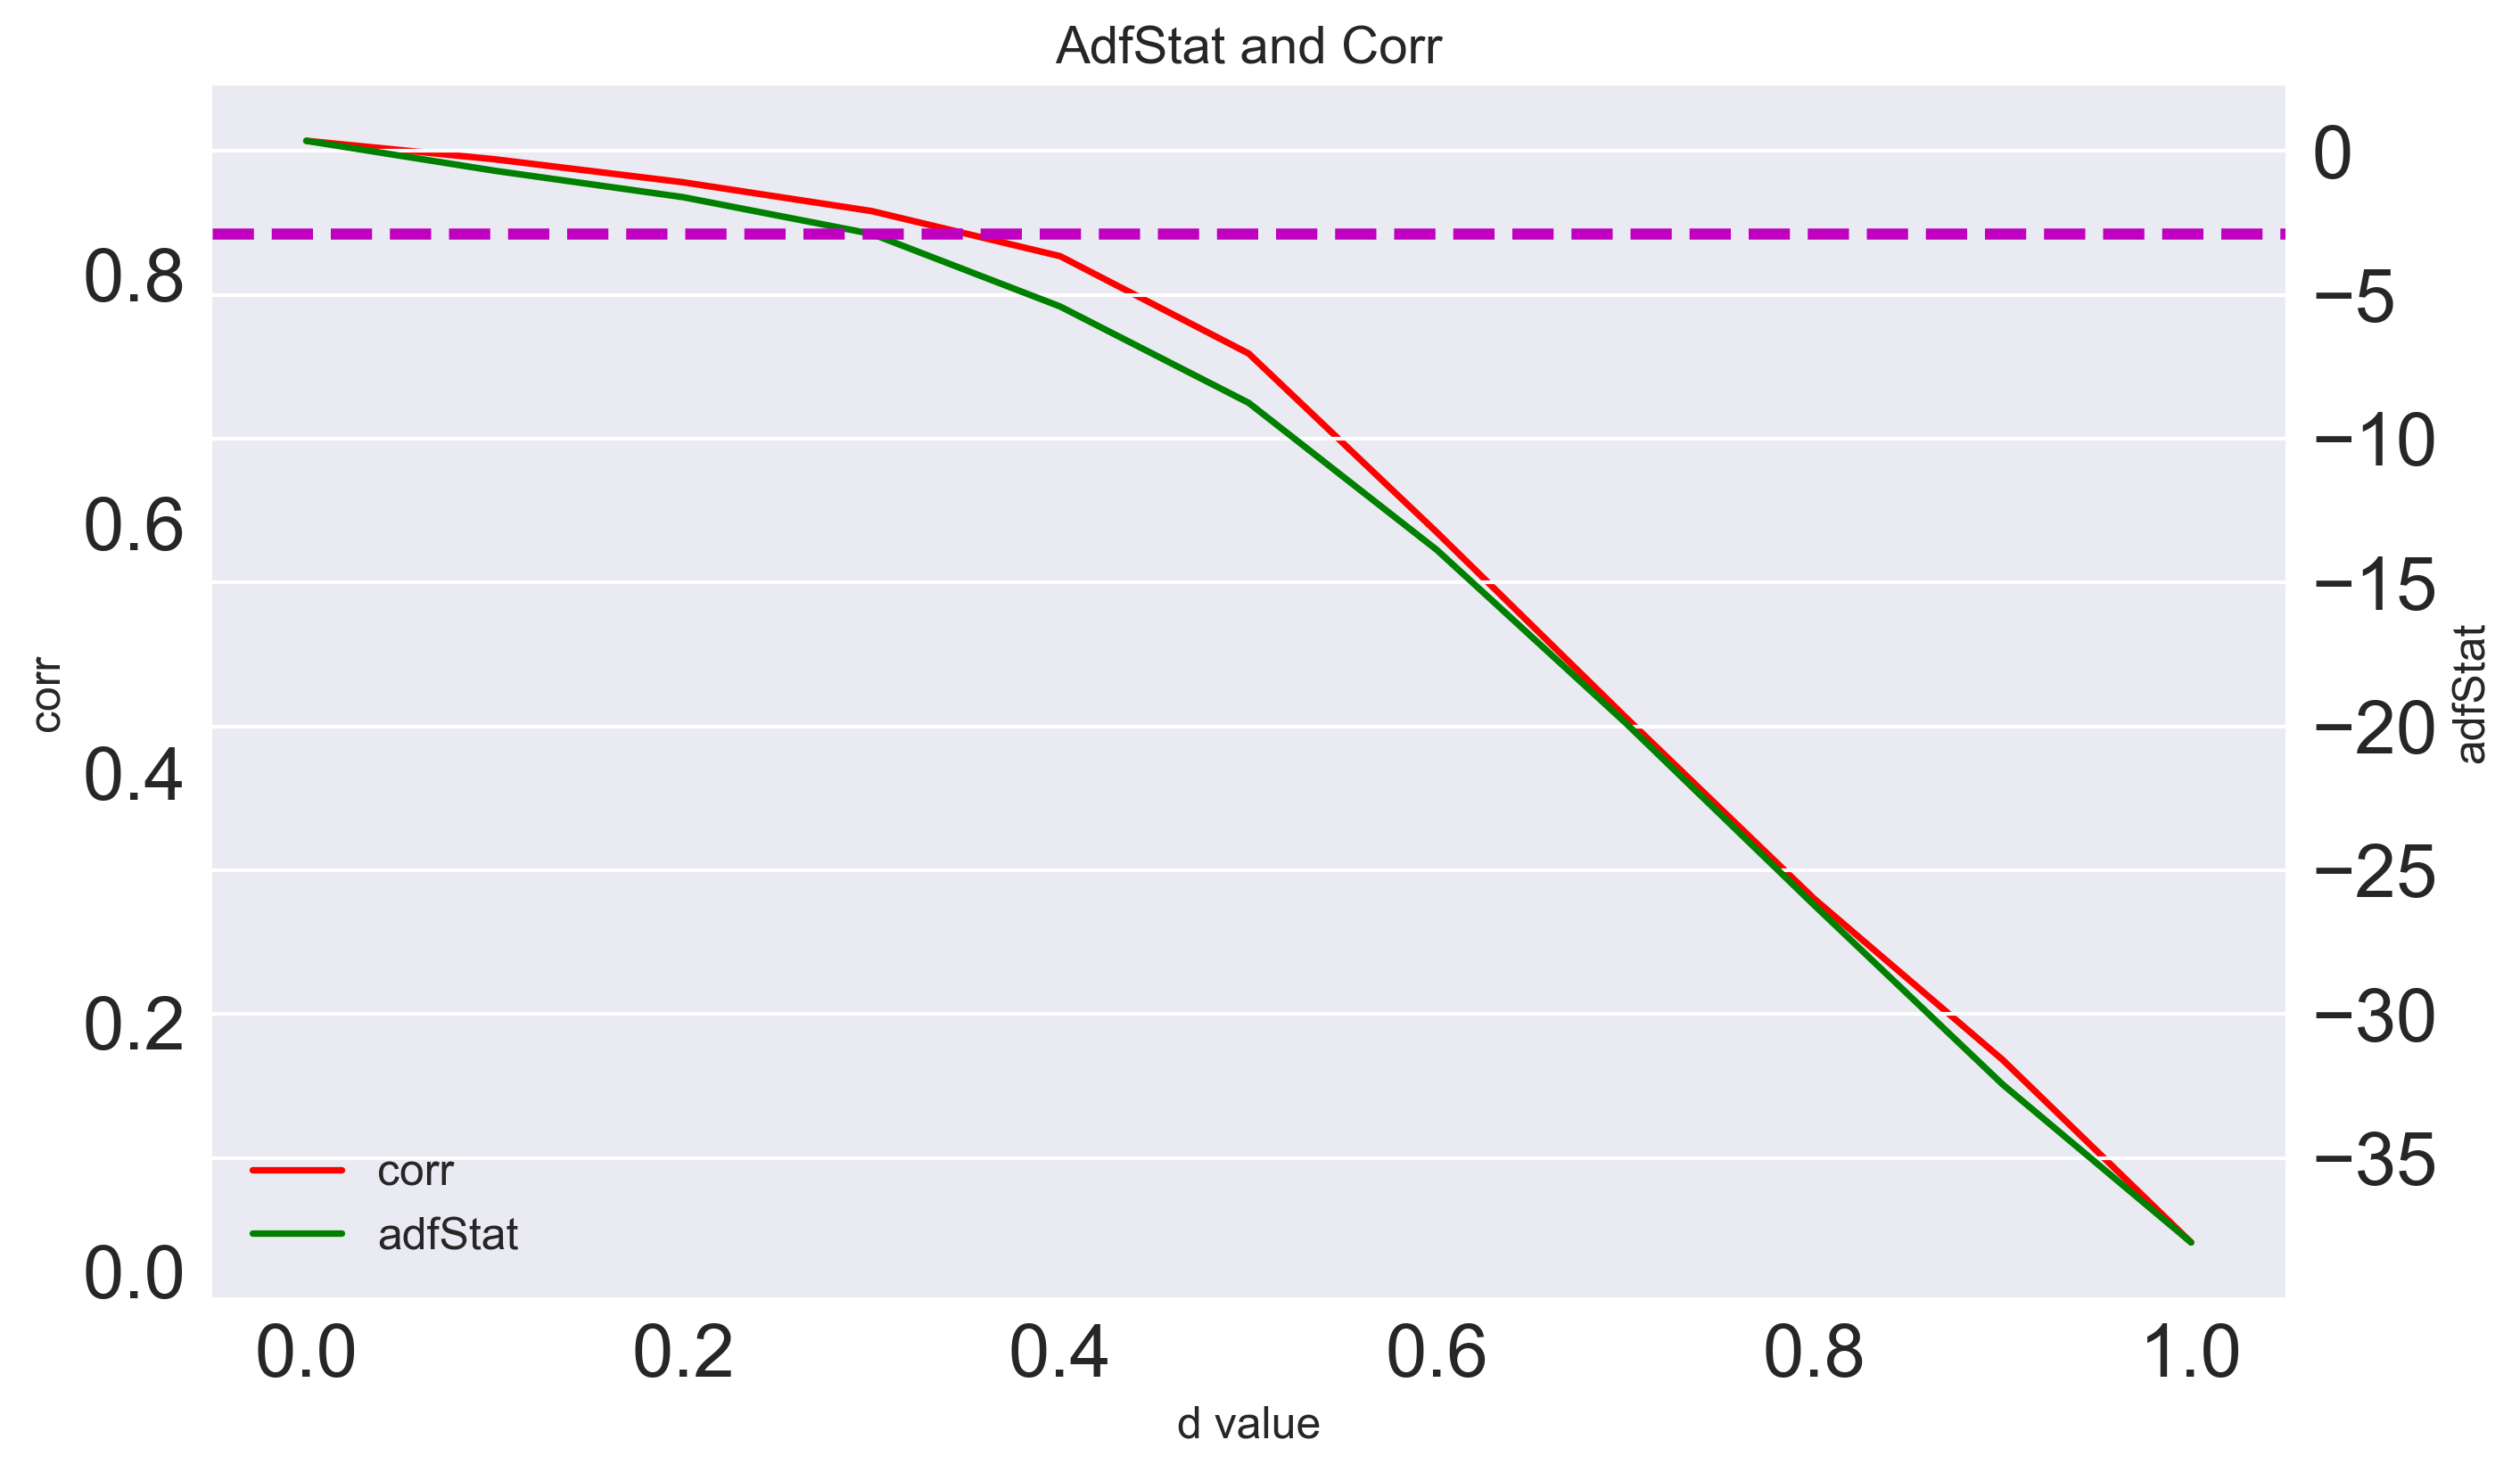

In [36]:
ax1 = out['corr'].plot(figsize=(10, 6), color='r')
ax2 = out['adfStat'].plot(secondary_y=True, fontsize=20, color='g', ax=ax1)
ax1.set_title('AdfStat and Corr', fontsize=14)
ax1.set_xlabel('d value', fontsize=12)
ax1.set_ylabel('corr', fontsize=12)
ax2.set_ylabel('adfStat', fontsize=12)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=12)
plt.axhline(out['95% conf'].mean(),linewidth=3, color='m',linestyle='--');